In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, r2_score
!pip install prophet --quiet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
orders = pd.read_csv('/content/drive/My Drive/Project_Final/olist_orders_dataset.csv')
order_items = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_items_dataset.csv')
customers = pd.read_csv('/content/drive/My Drive/Project_Final/olist_customers_dataset.csv')
reviews = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_reviews_dataset.csv')
payments = pd.read_csv('/content/drive/My Drive/Project_Final/olist_order_payments_dataset.csv')
products = pd.read_csv('/content/drive/My Drive/Project_Final/olist_products_dataset.csv')
sellers = pd.read_csv("/content/drive/My Drive/Project_Final/olist_sellers_dataset.csv")
geolocation = pd.read_csv("/content/drive/My Drive/Project_Final/olist_geolocation_dataset.csv")
cat_translation = pd.read_csv("/content/drive/My Drive/Project_Final/product_category_name_translation.csv")

#Ki·ªÉm tra missing v√† duplicate d·ªØ li·ªáu

In [211]:
def check_missing_and_duplicates(df, name):
    print(f"--- {name} ---")
    print("Missing:\n", df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))
    print("Duplicated:", df.duplicated().sum())
    print(df.info())
    print()

check_missing_and_duplicates(orders, "orders")
check_missing_and_duplicates(customers, "customers")
check_missing_and_duplicates(order_items, "order_items")
check_missing_and_duplicates(products, "products")
check_missing_and_duplicates(payments, "payments")
check_missing_and_duplicates(reviews, "reviews")
check_missing_and_duplicates(sellers, "sellers")
check_missing_and_duplicates(geolocation, "geo")
check_missing_and_duplicates(cat_translation, "cat_translation")

--- orders ---
Missing:
 order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
dtype: int64
Duplicated: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None

--- customers ---
Missing:
 Series([], dtype: int64)
Duplicated: 0
<class 'pandas.core.fra

#X·ª≠ l√Ω missing Orders

In [212]:
# Lo·∫°i ƒë∆°n ch∆∞a giao
orders = orders[orders['order_delivered_customer_date'].notnull()]
orders = orders[orders['order_delivered_carrier_date'].notnull()]

# ƒêi·ªÅn thi·∫øu ng√†y x√°c nh·∫≠n
# V·ªõi m·ªôt s·ªë ƒë∆°n h√†ng thi·∫øu th·ªùi gian x√°c nh·∫≠n, h·ªá th·ªëng gi·∫£ ƒë·ªãnh vi·ªác x√°c nh·∫≠n x·∫£y ra ngay khi ƒë·∫∑t h√†ng.
orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)

/tmp/ipython-input-212-1680994181.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)
/tmp/ipython-input-212-1680994181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)


#X·ª≠ l√Ω Missing Preview

In [213]:
# Do h∆°n 80% ng∆∞·ªùi d√πng kh√¥ng ƒë·ªÉ l·∫°i n·ªôi dung b√¨nh lu·∫≠n, ch·ªâ cung c·∫•p ƒëi·ªÉm ƒë√°nh gi√° (review_score),
# n√™n hai tr∆∞·ªùng review_comment_title v√† review_comment_message ƒë∆∞·ª£c lo·∫°i b·ªè trong qu√° tr√¨nh x·ª≠ l√Ω d·ªØ li·ªáu
# ƒë·ªÉ gi·∫£m nhi·ªÖu v√† t·∫≠p trung v√†o ph√¢n t√≠ch h√†nh vi ch√≠nh.
reviews.drop(columns=['review_comment_title', 'review_comment_message'], inplace=True)

#X·ª≠ l√Ω Missing Product

In [214]:
products['product_category_name'].fillna('unknown', inplace=True)
# ƒê·ªô d√†i t√™n s·∫£n ph·∫©m, ƒê·ªô d√†i m√¥ t·∫£ s·∫£n ph·∫©m, S·ªë ·∫£nh s·∫£n ph·∫©m c√≥ th·ªÉ lo·∫°i b·ªè v√¨ kh√¥ng ·∫£nh h∆∞·ªüng
products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty'], inplace=True)
# T√≠nh trung b√¨nh c·ªôt c√¢n n·∫∑ng, chi·ªÅu cao, ƒë·ªô d√†i s·∫£n ph·∫©m
product_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
products[product_cols] = products[product_cols].fillna(products[product_cols].mean())

/tmp/ipython-input-214-3715294945.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['product_category_name'].fillna('unknown', inplace=True)


#X·ª≠ l√Ω ki·ªÉu d·ªØ li·ªáu

##Orders

In [215]:
orders['order_id'] = orders['order_id'].astype('string')
orders['customer_id'] = orders['customer_id'].astype('string')
orders['order_status'] = orders['order_status'].astype('category')

In [216]:
# Chuy·ªÉn ƒë·ªïi ki·ªÉu ng√†y th√°ng
orders_date = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
               'order_delivered_customer_date', 'order_estimated_delivery_date']
orders[orders_date] = orders[orders_date].apply(pd.to_datetime)

##Reviews

In [217]:
reviews['review_id'] = reviews['review_id'].astype('string')
reviews['order_id'] = reviews['order_id'].astype('string')

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

##Products

In [218]:
products['product_id'] = products['product_id'].astype('string')
products['product_category_name'] = products['product_category_name'].astype('string')

##Payments

In [219]:
payments['order_id'] = payments['order_id'].astype('string')
payments['payment_type'] = payments['payment_type'].astype('category')

##Order_items

In [220]:
order_items['order_id'] = order_items['order_id'].astype('string')
order_items['product_id'] = order_items['product_id'].astype('string')
order_items['seller_id'] = order_items['seller_id'].astype('string')

order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

##Customers

In [221]:
customers['customer_id'] = customers['customer_id'].astype('string')
customers['customer_unique_id'] = customers['customer_unique_id'].astype('string')
customers['customer_city'] = customers['customer_city'].astype('string')
customers['customer_state'] = customers['customer_state'].astype('string')

##Sellers

In [222]:
sellers['seller_id'] = sellers['seller_id'].astype('string')
sellers['seller_city'] = sellers['seller_city'].astype('string')
sellers['seller_state'] = sellers['seller_state'].astype('string')

##Geo

In [223]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].astype('string')
geolocation['geolocation_state'] = geolocation['geolocation_state'].astype('string')

In [224]:
cat_translation['product_category_name'] = cat_translation['product_category_name'].astype('string')
cat_translation['product_category_name_english'] = cat_translation['product_category_name_english'].astype('string')

#Merge

In [225]:
order_items['total_price'] = order_items['price'] + order_items['freight_value']

payments_agg = payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_type': lambda x: ','.join(set(x))
}).reset_index()

reviews_agg = reviews.groupby('order_id').agg({
    'review_score': 'median'
}).reset_index()

df_all = order_items.copy()

df_all = df_all.merge(orders, on='order_id', how='left')

df_all = df_all.merge(products, on='product_id', how='left')
df_all = df_all.merge(cat_translation, on='product_category_name', how='left')

df_all = df_all.merge(sellers, on='seller_id', how='left')

df_all = df_all.merge(customers, on='customer_id', how='left')

df_all = df_all.merge(payments_agg, on='order_id', how='left')

df_all = df_all.merge(reviews_agg, on='order_id', how='left')


In [226]:
df_clean = df_all.copy()

df_clean = df_clean[~df_clean["product_category_name"].isnull()]

df_clean["product_category_name_english"] = df_clean["product_category_name_english"].fillna("unknown")

size_cols = ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]
for col in size_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


In [227]:
df_clean = df_clean[~df_clean['order_purchase_timestamp'].isnull()].copy()

In [228]:
df_clean = df_clean[~df_clean['payment_value'].isnull()]

In [229]:
df_clean['has_review'] = df_clean['review_score'].notnull().astype(int)

/tmp/ipython-input-229-1541678638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['has_review'] = df_clean['review_score'].notnull().astype(int)


In [230]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110192 entries, 0 to 112649
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110192 non-null  string        
 1   order_item_id                  110192 non-null  int64         
 2   product_id                     110192 non-null  string        
 3   seller_id                      110192 non-null  string        
 4   shipping_limit_date            110192 non-null  datetime64[ns]
 5   price                          110192 non-null  float64       
 6   freight_value                  110192 non-null  float64       
 7   total_price                    110192 non-null  float64       
 8   customer_id                    110192 non-null  string        
 9   order_status                   110192 non-null  category      
 10  order_purchase_timestamp       110192 non-null  datetime64[ns]
 11  order

In [231]:
df_clean['order_purchase_timestamp'] = pd.to_datetime(df_clean['order_purchase_timestamp'])

df_clean['year_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').astype(str)
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.month
df_clean['order_year'] = df_clean['order_purchase_timestamp'].dt.year
df_clean['order_date'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()
df_clean['order_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.start_time
df_clean['order_dayofweek'] = df_clean['order_purchase_timestamp'].dt.dayofweek
df_clean['order_hour'] = df_clean['order_purchase_timestamp'].dt.hour
df_clean['purchase_dayofweek'] = df_clean['order_purchase_timestamp'].dt.day_name()

In [232]:
# T√≠nh th·ªùi gian giao h√†ng
df_clean['delivery_time'] = (df_clean['order_delivered_customer_date'] - df_clean['order_purchase_timestamp']).dt.days

# T√≠nh th·ªùi gian d·ª± ki·∫øn giao h√†ng
df_clean['estimated_time'] = (df_clean['order_estimated_delivery_date'] - df_clean['order_purchase_timestamp']).dt.days

# T√≠nh ƒë·ªô tr·ªÖ giao h√†ng (th·ª±c t·∫ø - d·ª± ki·∫øn)
df_clean['delivery_delay'] = (df_clean['order_delivered_customer_date'] - df_clean['order_estimated_delivery_date']).dt.days

# ƒê∆°n h√†ng c√≥ b·ªã tr·ªÖ kh√¥ng? (1 = tr·ªÖ, 0 = ƒë√∫ng/s·ªõm)
df_clean['is_late'] = (df_clean['delivery_delay'] > 0).astype(int)

df_clean['delivered_late'] = df_clean['order_delivered_customer_date'] > df_clean['order_estimated_delivery_date']

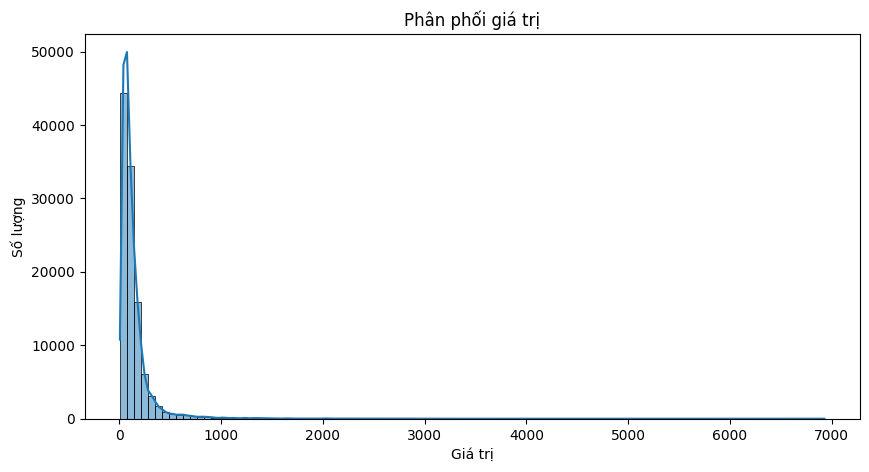

In [233]:
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['total_price'], bins=100, kde=True)
plt.title('Ph√¢n ph·ªëi gi√° tr·ªã')
plt.xlabel('Gi√° tr·ªã')
plt.ylabel('S·ªë l∆∞·ª£ng')
plt.show()

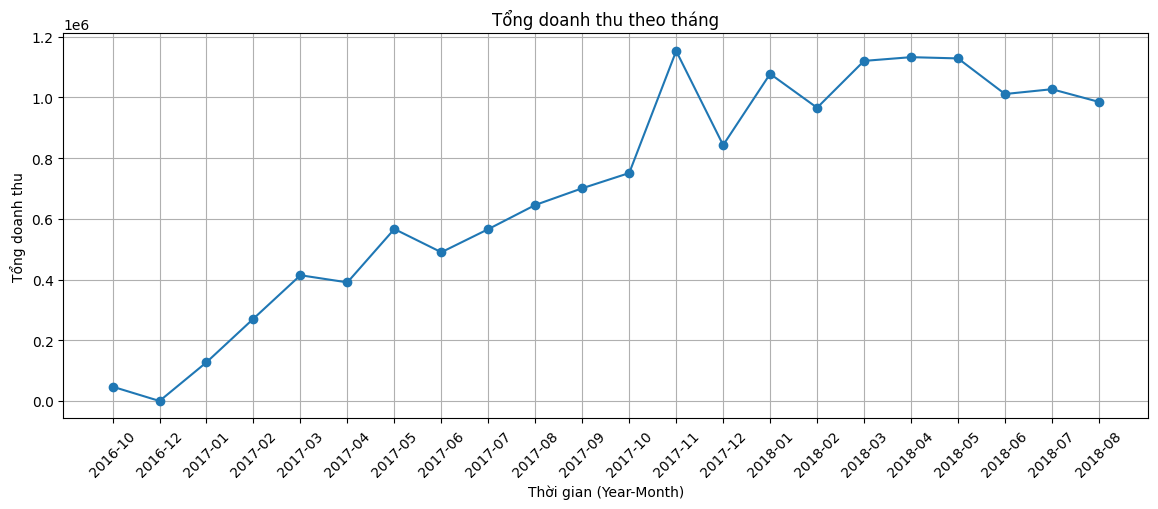

In [234]:
#Doanh thu theo th√°ng
monthly_revenue = df_clean.groupby(['order_year', 'order_month'])['total_price'].sum().reset_index()
monthly_revenue['year_month'] = monthly_revenue['order_year'].astype('string') + '-' + monthly_revenue['order_month'].astype('string').str.zfill(2)
monthly_revenue = monthly_revenue.drop(columns=['order_year', 'order_month'])

plt.figure(figsize=(14, 5))
plt.plot(monthly_revenue['year_month'], monthly_revenue['total_price'], marker='o')
plt.title('T·ªïng doanh thu theo th√°ng')
plt.xticks(rotation=45)
plt.xlabel('Th·ªùi gian (Year-Month)')
plt.ylabel('T·ªïng doanh thu')
plt.grid(True)
plt.show()

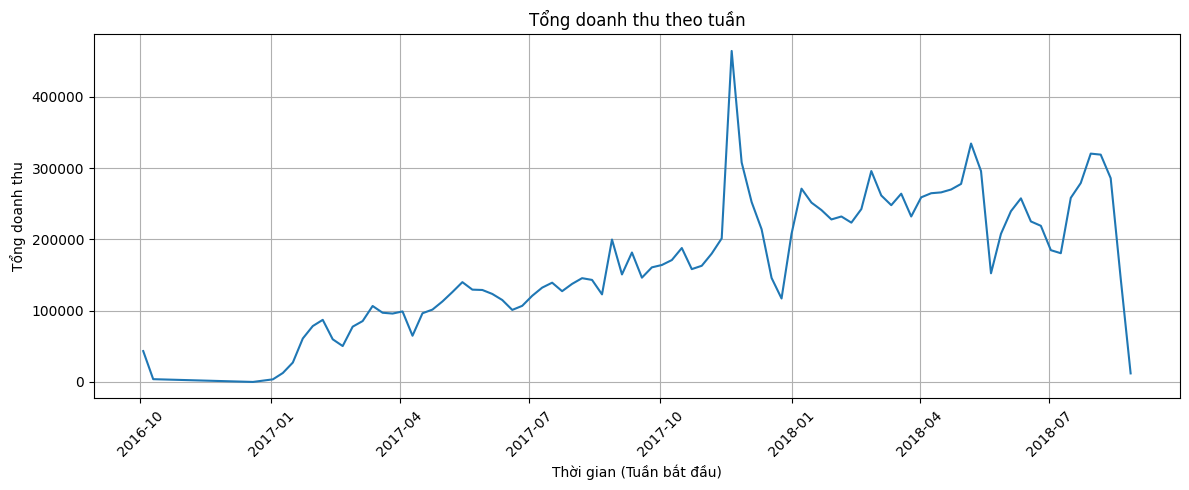

In [235]:
# T√≠nh doanh thu theo tu·∫ßn
weekly_revenue = df_clean.groupby('order_week')['total_price'].sum().reset_index()

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 5))
# weekly_revenue.plot(kind='line')
plt.plot(weekly_revenue['order_week'], weekly_revenue['total_price'])
plt.title('T·ªïng doanh thu theo tu·∫ßn')
plt.xticks(rotation=45)
plt.xlabel('Th·ªùi gian (Tu·∫ßn b·∫Øt ƒë·∫ßu)')
plt.ylabel('T·ªïng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

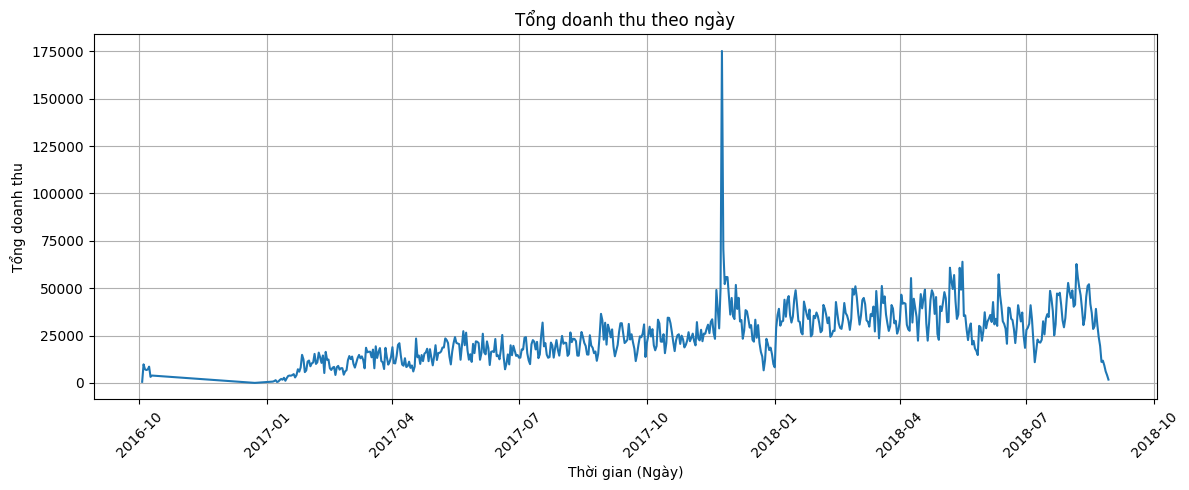

In [236]:
# T√≠nh doanh thu theo ng√†y
daily_revenue = df_clean.groupby('order_date')['total_price'].sum().reset_index()

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 5))
plt.plot(daily_revenue['order_date'], daily_revenue['total_price'])
plt.title('T·ªïng doanh thu theo ng√†y')
plt.xticks(rotation=45)
plt.xlabel('Th·ªùi gian (Ng√†y)')
plt.ylabel('T·ªïng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

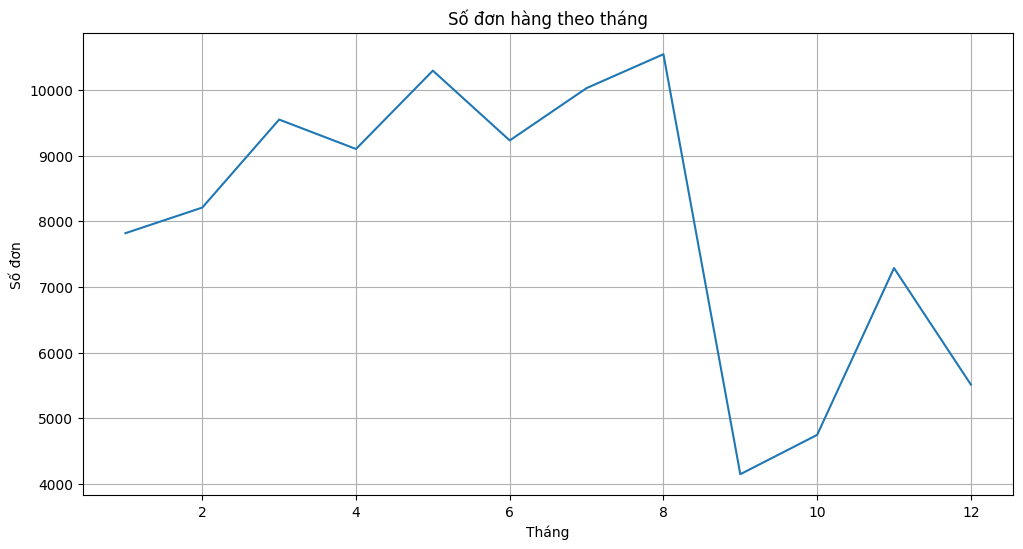

In [237]:
monthly_orders = df_clean.groupby('order_month')['order_id'].nunique()

plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line')
plt.title("S·ªë ƒë∆°n h√†ng theo th√°ng")
plt.xlabel("Th√°ng")
plt.ylabel("S·ªë ƒë∆°n")
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

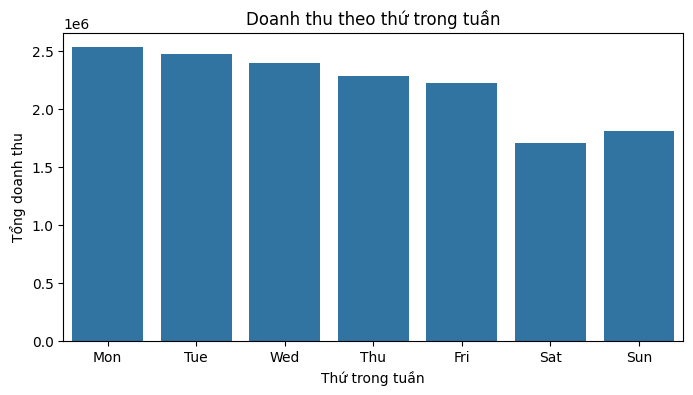

In [238]:
#Doanh thu theo th·ª© trong tu·∫ßn
day_map = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_revenue = df_clean.groupby('order_dayofweek')['total_price'].sum().reset_index()
day_revenue['day_name'] = day_revenue['order_dayofweek'].map(lambda x: day_map[x])

plt.figure(figsize=(8, 4))
sns.barplot(data=day_revenue, x='day_name', y='total_price', order=day_map)
plt.title('Doanh thu theo th·ª© trong tu·∫ßn')
plt.xlabel('Th·ª© trong tu·∫ßn')
plt.ylabel('T·ªïng doanh thu')
plt.show()

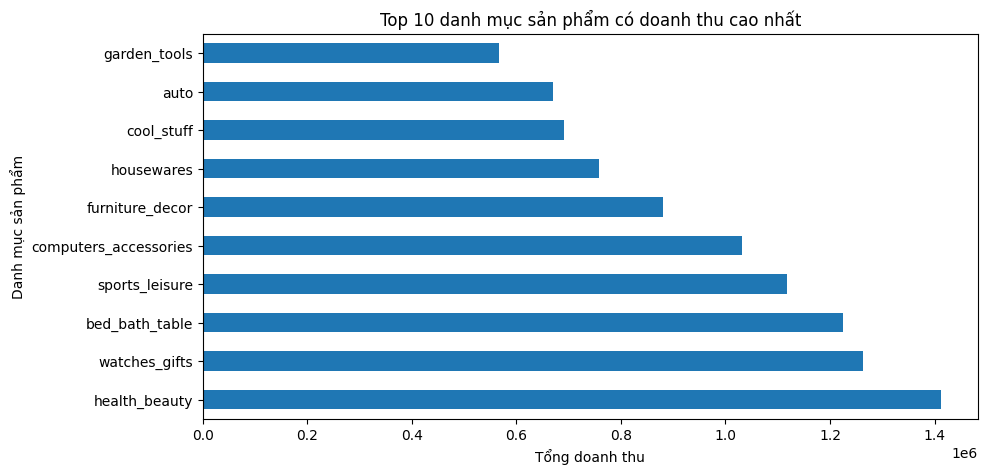

In [239]:
#Doaanh thu theo s·∫£n ph·∫©m
top_cats = df_clean.groupby('product_category_name_english')['total_price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_cats.plot(kind='barh')
# sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title('Top 10 danh m·ª•c s·∫£n ph·∫©m c√≥ doanh thu cao nh·∫•t')
plt.xlabel('T·ªïng doanh thu')
plt.ylabel('Danh m·ª•c s·∫£n ph·∫©m')
plt.show()

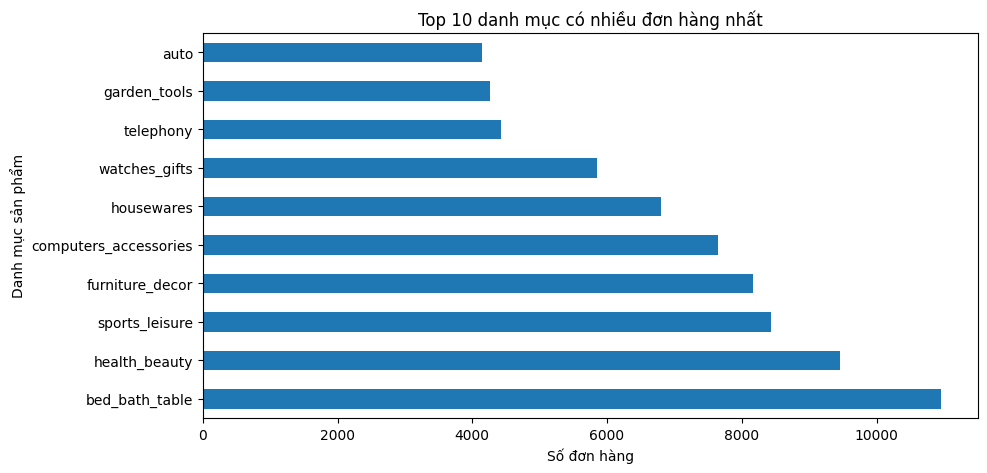

In [240]:
top_products_orders = df_clean['product_category_name_english'].value_counts().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_products_orders.plot(kind='barh')
plt.title("Top 10 danh m·ª•c c√≥ nhi·ªÅu ƒë∆°n h√†ng nh·∫•t")
plt.xlabel("S·ªë ƒë∆°n h√†ng")
plt.ylabel("Danh m·ª•c s·∫£n ph·∫©m")
plt.show()

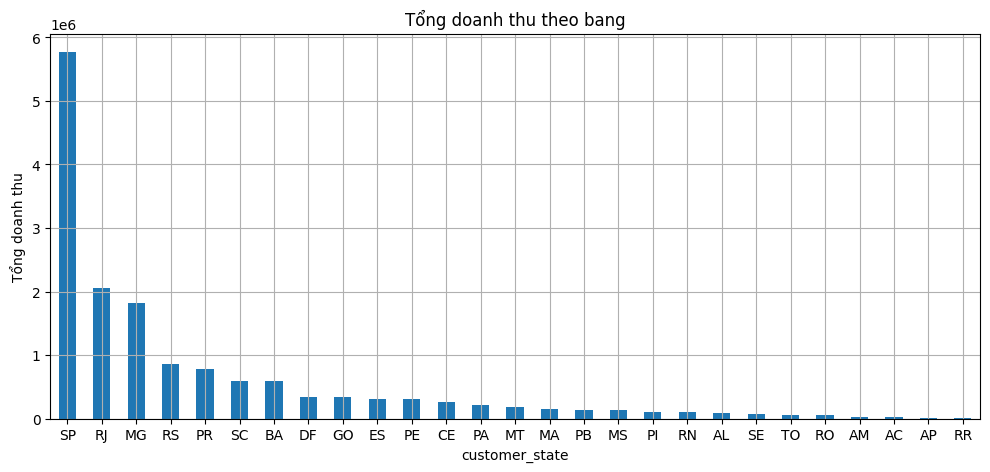

In [241]:
state_sales = df_clean.groupby('customer_state')['total_price'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,5))
state_sales.plot(kind='bar')
plt.ylabel("T·ªïng doanh thu")
plt.title("T·ªïng doanh thu theo bang")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

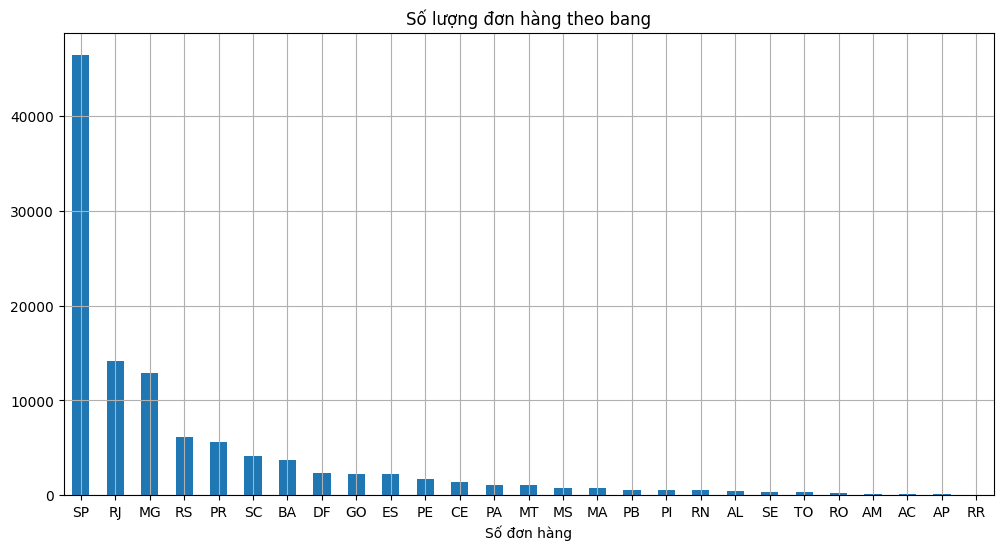

In [242]:
state_orders = df_clean['customer_state'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_orders.plot(kind='bar')
plt.title("S·ªë l∆∞·ª£ng ƒë∆°n h√†ng theo bang")
plt.xlabel("S·ªë ƒë∆°n h√†ng")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

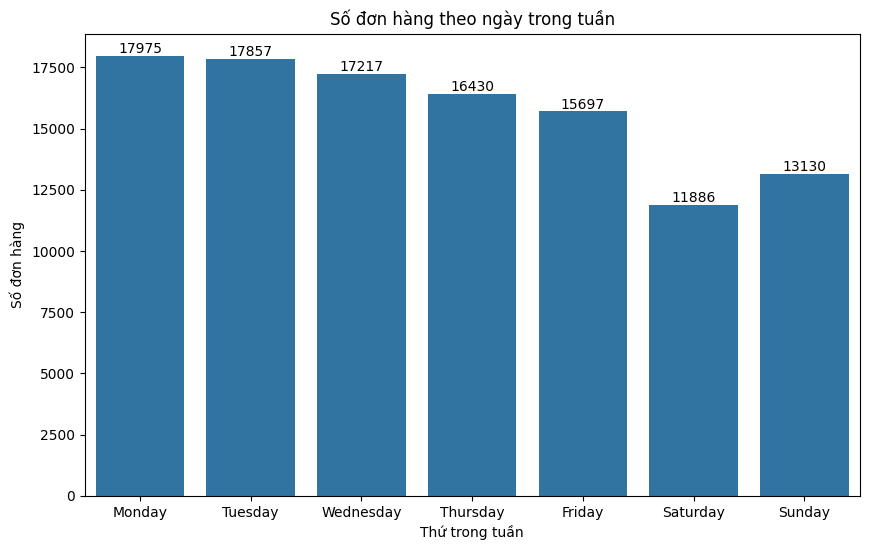

In [243]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_clean, x='purchase_dayofweek',
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title("S·ªë ƒë∆°n h√†ng theo ng√†y trong tu·∫ßn")
plt.xlabel("Th·ª© trong tu·∫ßn")
plt.ylabel("S·ªë ƒë∆°n h√†ng")
plt.show()

In [244]:
df_clean.groupby('purchase_dayofweek')['total_price'].sum().reset_index()

purchase_dayofweek  total_price
0             Friday   2222392.98
1             Monday   2530173.73
2           Saturday   1705913.92
3             Sunday   1807391.64
4           Thursday   2283533.57
5            Tuesday   2473553.80
6          Wednesday   2395846.33

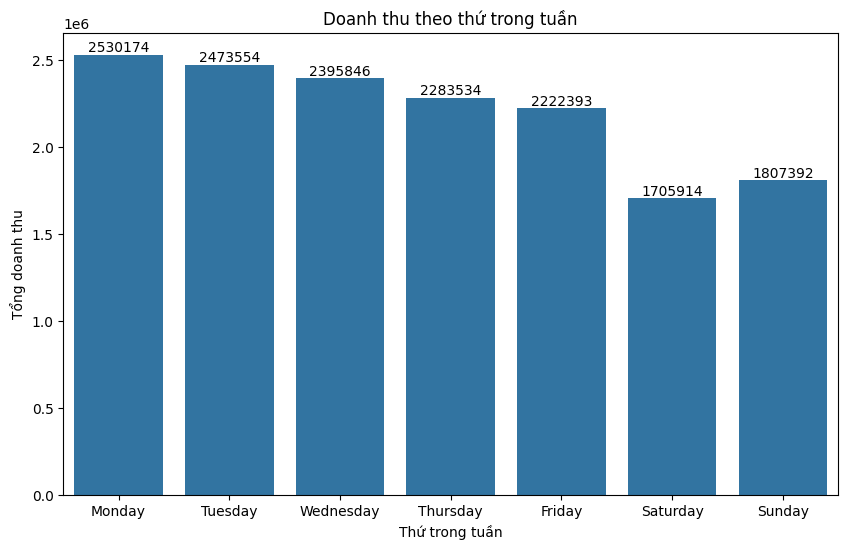

In [245]:
#Doanh thu theo th·ª© trong tu·∫ßn
day_revenue = df_clean.groupby('purchase_dayofweek')['total_price'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=day_revenue, x='purchase_dayofweek', y='total_price',  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.title('Doanh thu theo th·ª© trong tu·∫ßn')
plt.xlabel('Th·ª© trong tu·∫ßn')
plt.ylabel('T·ªïng doanh thu')
plt.show()

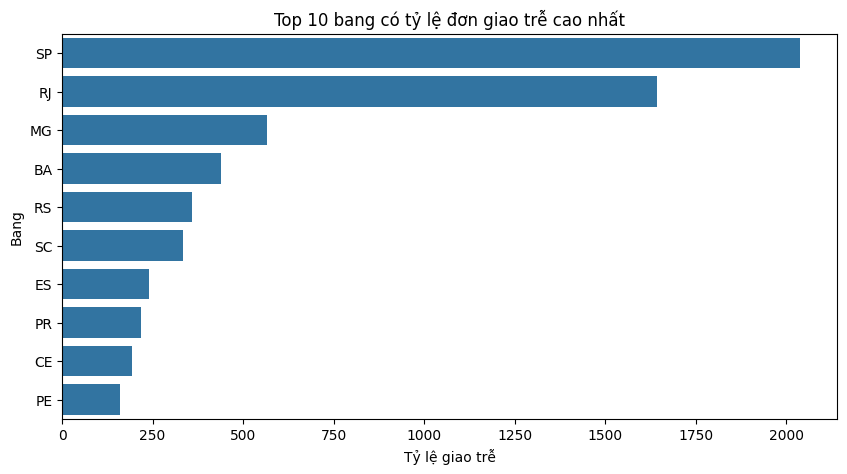

In [246]:
late_ratio_by_state = df_clean.groupby('customer_state')['is_late'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=late_ratio_by_state.values, y=late_ratio_by_state.index)
plt.title("Top 10 bang c√≥ t·ª∑ l·ªá ƒë∆°n giao tr·ªÖ cao nh·∫•t")
plt.xlabel("T·ª∑ l·ªá giao tr·ªÖ")
plt.ylabel("Bang")
plt.show()

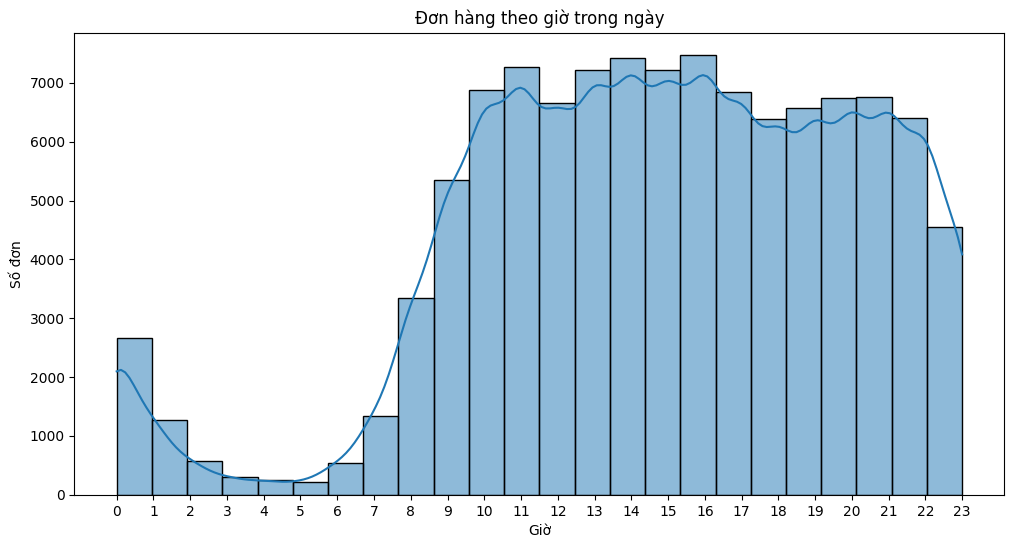

In [247]:
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['order_hour'], bins=24, kde=True)
plt.title("ƒê∆°n h√†ng theo gi·ªù trong ng√†y")
plt.xlabel("Gi·ªù")
plt.ylabel("S·ªë ƒë∆°n")
plt.xticks(range(0,24))
plt.show()

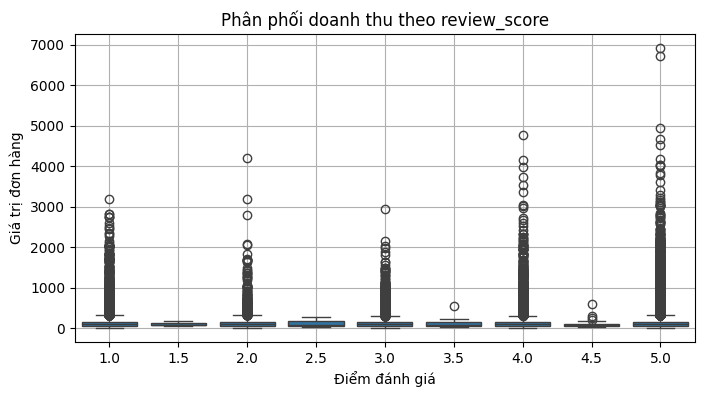

In [248]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x='review_score', y='total_price')
plt.title('Ph√¢n ph·ªëi doanh thu theo review_score')
plt.xlabel('ƒêi·ªÉm ƒë√°nh gi√°')
plt.ylabel('Gi√° tr·ªã ƒë∆°n h√†ng')
plt.grid(True)
plt.show()

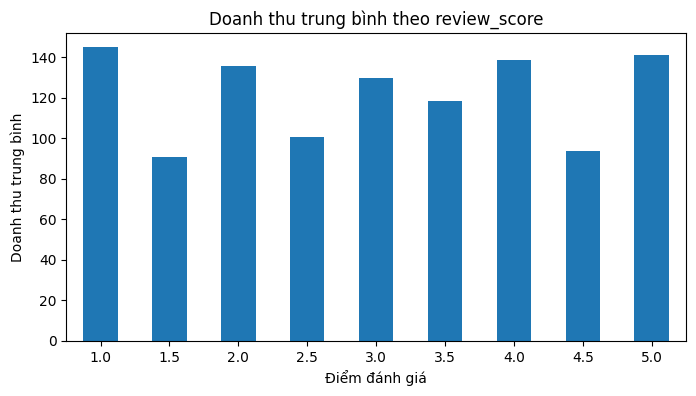

In [249]:
df_clean.groupby('review_score')['total_price'].mean().plot(kind='bar', figsize=(8, 4), title='Doanh thu trung b√¨nh theo review_score')
plt.xticks(rotation=0)
plt.xlabel('ƒêi·ªÉm ƒë√°nh gi√°')
plt.ylabel('Doanh thu trung b√¨nh')
plt.show()


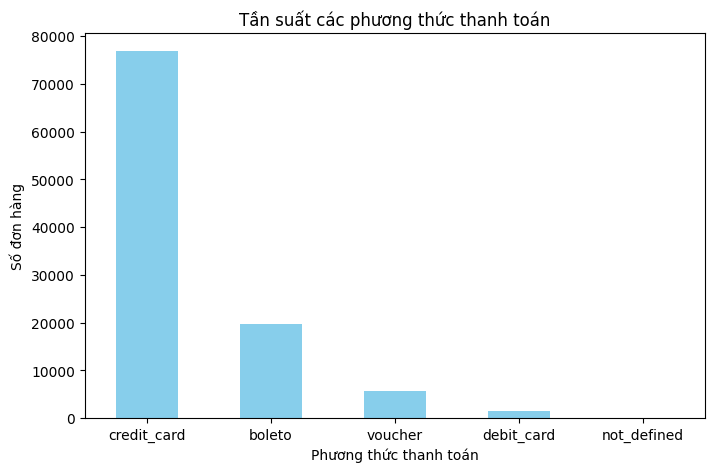

In [250]:
payment_fre = payments['payment_type'].value_counts()
plt.figure(figsize=(8, 5))
payment_fre.plot(kind='bar', color='skyblue')
plt.title("T·∫ßn su·∫•t c√°c ph∆∞∆°ng th·ª©c thanh to√°n")
plt.xlabel("Ph∆∞∆°ng th·ª©c thanh to√°n")
plt.ylabel("S·ªë ƒë∆°n h√†ng")
plt.xticks(rotation=0)
plt.show()

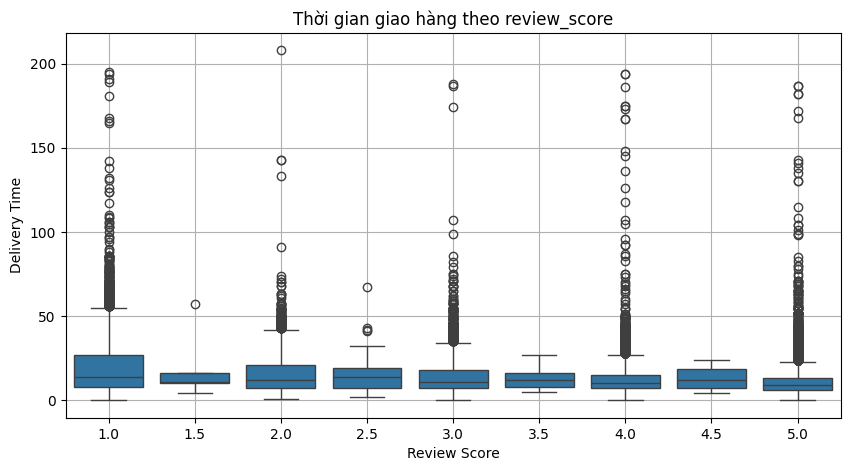

In [251]:
#Th·ªùi gian giao h√†ng v·ªõi review
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean, x='review_score', y='delivery_time')
plt.title('Th·ªùi gian giao h√†ng theo review_score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time')
plt.grid(True)
plt.show()

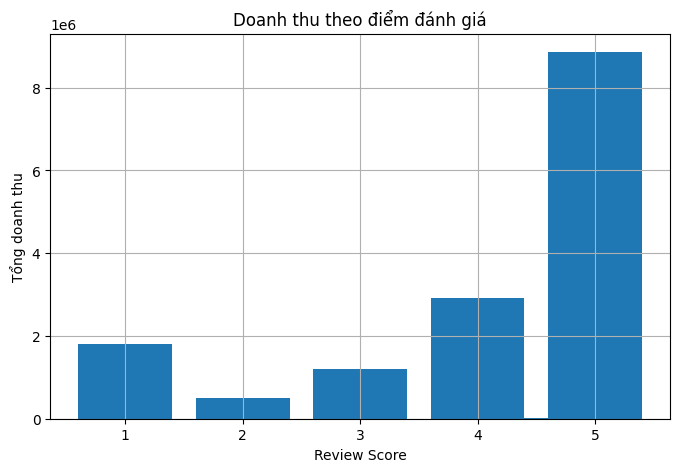

In [294]:
review_stats = df_clean.groupby('review_score')['total_price'].sum().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(review_stats['review_score'], review_stats['total_price'])
plt.xlabel("Review Score")
plt.ylabel("T·ªïng doanh thu")
plt.title("Doanh thu theo ƒëi·ªÉm ƒë√°nh gi√°")
plt.grid(True)
plt.show()

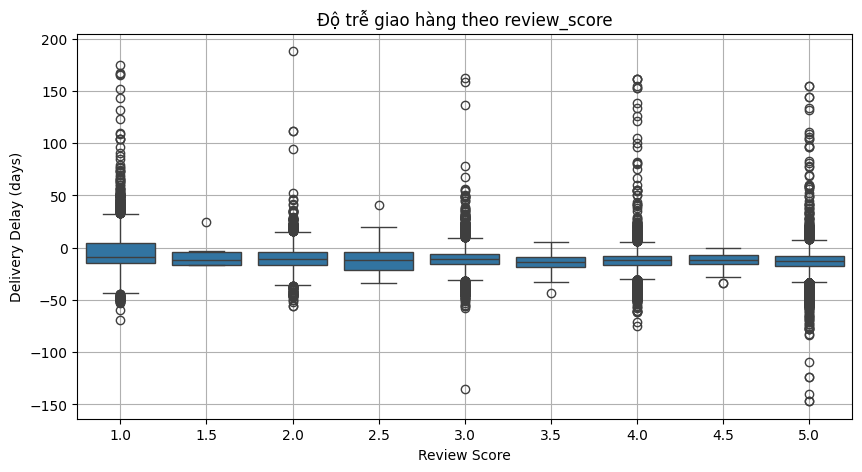

In [252]:
#ƒê·ªô tr·ªÖ giao h√†ng vs review
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean[df_clean['delivery_delay'].notnull()], x='review_score', y='delivery_delay')
plt.title('ƒê·ªô tr·ªÖ giao h√†ng theo review_score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Delay (days)')
plt.grid(True)
plt.show()

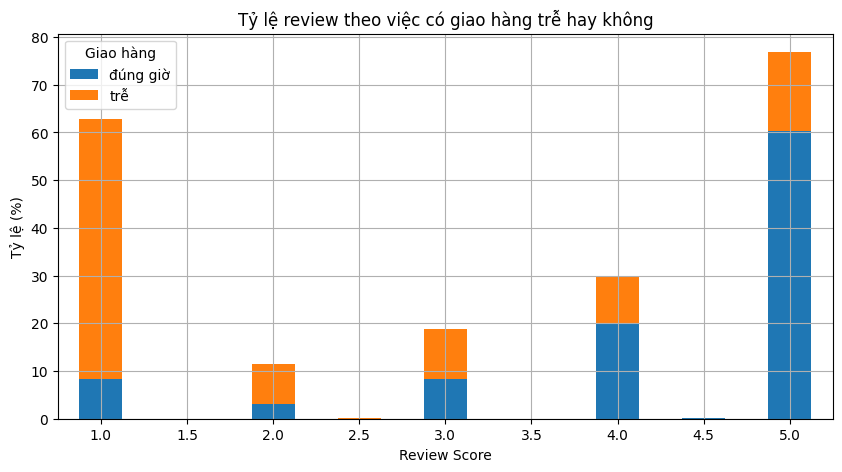

In [253]:
late_review = df_clean.groupby(['is_late', 'review_score']).size().unstack().fillna(0)

late_review_percent = late_review.div(late_review.sum(axis=1), axis=0) * 100

late_review_percent.T.plot(kind='bar', figsize=(10, 5), stacked=True)
plt.title('T·ª∑ l·ªá review theo vi·ªác c√≥ giao h√†ng tr·ªÖ hay kh√¥ng')
plt.xlabel('Review Score')
plt.ylabel('T·ª∑ l·ªá (%)')
plt.legend(['ƒë√∫ng gi·ªù', 'tr·ªÖ'], title='Giao h√†ng')
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

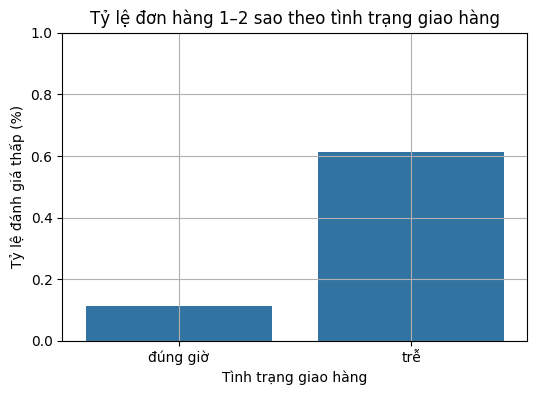

In [254]:
#Tr·ªÖ giao h√†ng c√≥ l√†m tƒÉng ƒë∆°n h√†ng 1‚Äì2 sao
df_clean['low_review'] = df_clean['review_score'].isin([1, 2]).astype(int)

# T√≠nh t·ª∑ l·ªá ƒë∆°n review th·∫•p gi·ªØa nh√≥m tr·ªÖ v√† kh√¥ng tr·ªÖ
late_review_rate = df_clean.groupby('is_late')['low_review'].mean().reset_index()
late_review_rate.columns = ['is_late', 'low_review_rate']

plt.figure(figsize=(6, 4))
sns.barplot(data=late_review_rate, x='is_late', y='low_review_rate')
plt.xticks([0, 1], ['ƒë√∫ng gi·ªù', 'tr·ªÖ'])
plt.title('T·ª∑ l·ªá ƒë∆°n h√†ng 1‚Äì2 sao theo t√¨nh tr·∫°ng giao h√†ng')
plt.ylabel('T·ª∑ l·ªá ƒë√°nh gi√° th·∫•p (%)')
plt.xlabel('T√¨nh tr·∫°ng giao h√†ng')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [255]:
# T·ªïng doanh thu to√†n b·ªô
total_revenue = df_clean['total_price'].sum()

# Doanh thu t·ª´ ƒë∆°n 1‚Äì2 sao
low_review_revenue = df_clean[df_clean['review_score'].isin([1, 2])]['total_price'].sum()

# T·ª∑ l·ªá
low_review_ratio = low_review_revenue / total_revenue

print(f"T·ªïng doanh thu: {total_revenue:,.2f}")
print(f"Doanh thu t·ª´ ƒë∆°n h√†ng review 1‚Äì2 sao: {low_review_revenue:,.2f}")
print(f"T·ª∑ l·ªá doanh thu t·ª´ kh√°ch kh√¥ng h√†i l√≤ng: {low_review_ratio*100:.2f}%")

T·ªïng doanh thu: 15,418,805.97
Doanh thu t·ª´ ƒë∆°n h√†ng review 1‚Äì2 sao: 2,298,098.49
T·ª∑ l·ªá doanh thu t·ª´ kh√°ch kh√¥ng h√†i l√≤ng: 14.90%


In [256]:
df_clean[df_clean['review_score'].isin([1, 2])].sort_values(by='total_price', ascending=False).head(10)


order_id  order_item_id  \
56663  80dfedb6d17bf23539beeef3c768f4d7              1   
95091  d7a2c0c1ff66b314f3bf166fb4157fd4              1   
36878  53c71d3953507c6239ff73917ed358c9              1   
23765  362aa88dd1265e7b4ea491b5836fb5f6              1   
20400  2ec398158cb686267b1f4b102129098e              1   
53308  794c69999774820e22c161f6dc4fef91              1   
96305  da8be3bb62e9bf01e2e1a3bfd74ebd1a              1   
77198  afc58387b17fa794fd73b0773a9f6ea7              1   
84126  bf205457ee84ab84c423d67b88239982              1   
72727  a5d11ae16578088b0fcd76de30368bdb              1   

                             product_id                         seller_id  \
56663  4ca7b91a31637bd24fb8e559d5e015e4  59417c56835dd8e2e72f91f809cd4092   
95091  2b69866f22de8dad69c976771daba91c  6bd69102ab48df500790a8cecfc285c2   
36878  17d98fc630d23a628ec1130f8d69d1d2  f9244d45189d3a3605499abddeade7d5   
23765  d7324d4c913e7b424cb61675dafc8c10  6750d71153f00fc58829af2a8ef1bcf1   
20400  15151e8a937f6a4d1a4f0c03c765c6f2  1444c08e64d55fb3c25f0f09c07ffcf2   
53308  0e030462875259ec0cb868f7ecf1fd5e  abe021b01ba992245271b9aa422032df   
96305  cea7edf64d9e93fbf6b89cc3ba537cd9  a4b6b9b992b46e9ef863637af96e04bc   
77198  3ecf69ee1fe21cfd40b30cbea549e563  59417c56835dd8e2e72f91f809cd4092   
84126  a233df9a388d27dbdfd31731d4236db0  784ba75dd9d20200c4caed3d7a77141a   
72727  0abc19e41fdc9d6894b8cae651619253  17e34d8224d27a541263c4c64b11a56b   

      shipping_limit_date    price  freight_value  total_price  \
56663 2017-05-05 20:50:13  3999.00         195.76      4194.76   
95091 2017-11-26 22:39:22  2990.00         194.55      3184.55   
36878 2018-08-13 20:55:31  3109.99          74.35      3184.34   
23765 2017-05-23 02:10:12  2799.00          28.00      2827.00   
20400 2018-05-11 12:15:17  2749.00          69.74      2818.74   
53308 2017-05-30 06:35:23  2740.00          54.50      2794.50   
96305 2017-04-12 13:55:17  2690.00          61.24      2751.24   
77198 2017-07-05 06:35:14  2690.00          44.11      2734.11   
84126 2017-12-29 15:30:45  2649.99          83.64      2733.63   
72727 2018-03-21 17:15:45  2433.60         157.01      2590.61   

                            customer_id order_status  ... order_week  \
56663  926b6a6fb8b6081e00b335edaf578d35    delivered  ... 2017-04-17   
95091  c26acf0451e0f8ec1f5218731b9a51cf    delivered  ... 2017-11-20   
36878  26dcb450c4b5b390e79e6d5d0f2c6535    delivered  ... 2018-07-23   
23765  1be0dd2f660a5a04ee20d608075f1b83    delivered  ... 2017-05-15   
20400  fced842c7dad61e8ce47b49229659718    delivered  ... 2018-04-23   
53308  8e2c57611e09e143ec4ab76e38033bef    delivered  ... 2017-05-08   
96305  3f083b9f62e687be8d84684c7d54c8db    delivered  ... 2017-04-03   
77198  19365ad6a18ccf1baf6eb71c30651096    delivered  ... 2017-06-12   
84126  695476b5848d64ba0875324c88390206    delivered  ... 2017-12-18   
72727  9c5d7103954595e173781530b10d02e4    delivered  ... 2018-03-12   

      order_dayofweek order_hour purchase_dayofweek delivery_time  \
56663               1         20            Tuesday            15   
95091               0         22             Monday            52   
36878               1         20            Tuesday             8   
23765               1         17            Tuesday            12   
20400               5         12           Saturday            10   
53308               1         14            Tuesday            31   
96305               3         13           Thursday            31   
77198               6         18             Sunday            17   
84126               3         15           Thursday            36   
72727               3         16           Thursday            36   

      estimated_time  delivery_delay  is_late  delivered_late  low_review  
56663             27             -12        0           False           1  
95091             28              23        1            True           1  
36878             27             -19

#C√¢u h·ªèi:

##T·∫°i sao t·ª∑ l·ªá giao h√†ng tr·ªÖ v·∫´n t·ªìn t·∫°i, nh∆∞ng doanh thu v·∫´n tƒÉng ƒë·ªÅu theo th·ªùi gian?

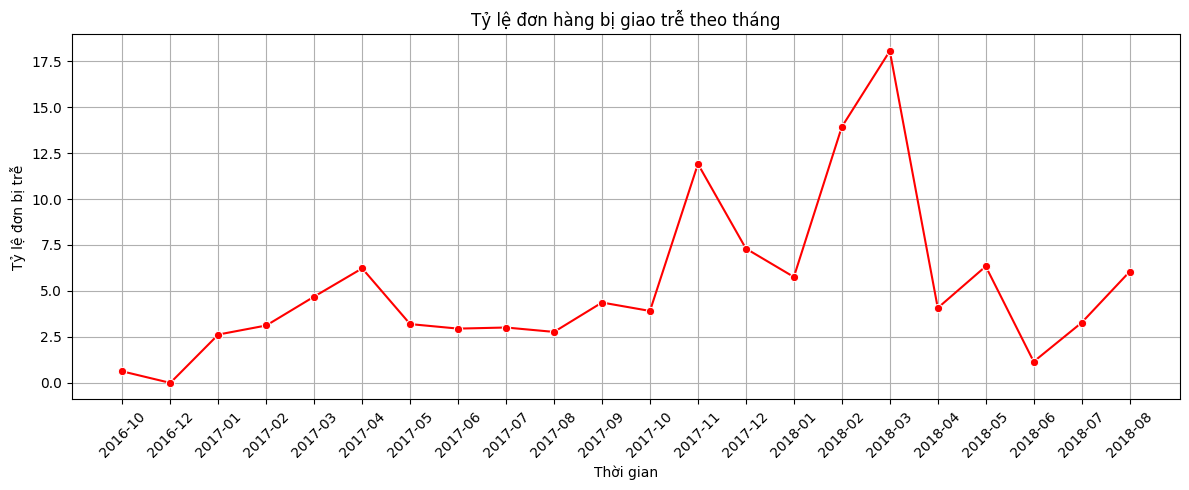

In [257]:
# T·ª∑ l·ªá ƒë∆°n tr·ªÖ theo th√°ng
monthly_late = df_clean.groupby('year_month')['is_late'].mean().reset_index()
monthly_late['is_late'] = monthly_late['is_late'] * 100

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_late, x='year_month', y='is_late', marker='o', color='red')
plt.xticks(rotation=45)
plt.title('T·ª∑ l·ªá ƒë∆°n h√†ng b·ªã giao tr·ªÖ theo th√°ng')
plt.xlabel('Th·ªùi gian')
plt.ylabel('T·ª∑ l·ªá ƒë∆°n b·ªã tr·ªÖ')
plt.grid(True)
plt.tight_layout()
plt.show()

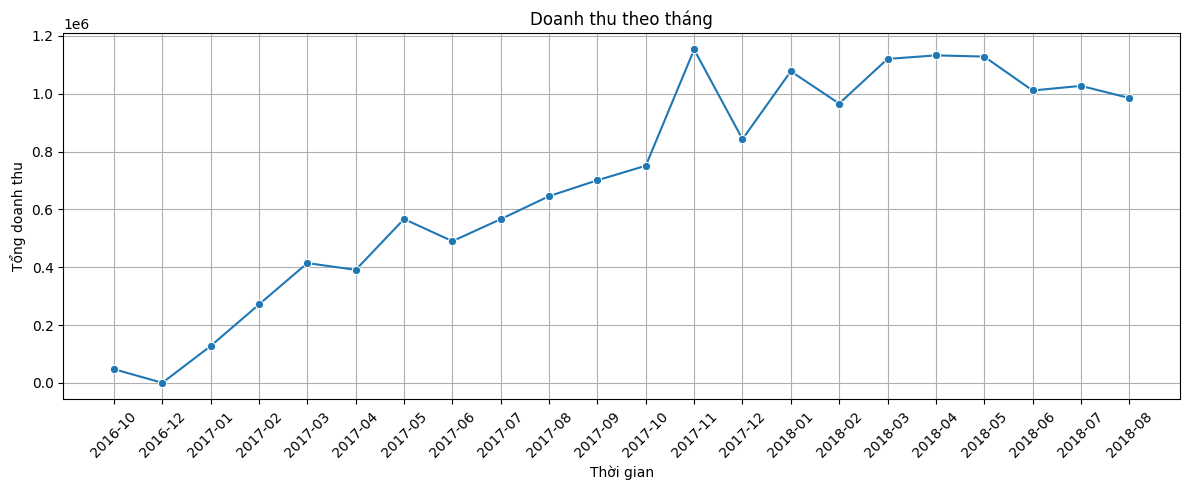

In [258]:


# T·ªïng doanh thu theo th√°ng
monthly_revenue = df_clean.groupby('year_month')['total_price'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_revenue, x='year_month', y='total_price', marker='o')
plt.xticks(rotation=45)
plt.title('Doanh thu theo th√°ng')
plt.xlabel('Th·ªùi gian')
plt.ylabel('T·ªïng doanh thu')
plt.grid(True)
plt.tight_layout()
plt.show()

Khi quan s√°t bi·ªÉu ƒë·ªì doanh thu theo th√°ng v√† t·ª∑ l·ªá ƒë∆°n h√†ng giao tr·ªÖ, ta ph√°t hi·ªán:

- T·ªïng doanh thu tƒÉng theo th·ªùi gian, b·∫•t ch·∫•p vi·ªác nhi·ªÅu ƒë∆°n b·ªã giao tr·ªÖ.

- Tuy nhi√™n, t·ª∑ l·ªá giao tr·ªÖ kh√¥ng gi·∫£m r√µ r·ªát, ƒë√¥i khi c√≤n tƒÉng nh·∫π.

ƒêi·ªÅu n√†y c√≥ th·ªÉ ƒë∆∞·ª£c l√Ω gi·∫£i b·ªüi:

- T·ªïng s·ªë ƒë∆°n h√†ng tƒÉng m·∫°nh -> k√©o doanh thu tƒÉng, d√π t·ª∑ l·ªá tr·ªÖ gi·ªØ nguy√™n

- Kh√°ch h√†ng ch·∫•p nh·∫≠n tr·ªÖ n·∫øu gi√° t·ªët ho·∫∑c s·∫£n ph·∫©m hi·∫øm

- C√°c danh m·ª•c c√≥ doanh thu l·ªõn (bed_bath_table, health_beauty,‚Ä¶) th∆∞·ªùng √≠t nh·∫°y c·∫£m v·ªõi t·ªëc ƒë·ªô giao h√†ng

- Olist v·∫´n chi·∫øm th·ªã ph·∫ßn t·ªët -> kh√°ch h√†ng ch∆∞a c√≥ l√Ω do ƒë·ªÉ r·ªùi b·ªè

In [259]:
total_revenue = df_clean['total_price'].sum()

# Doanh thu t·ª´ ƒë∆°n h√†ng c√≥ review 1‚Äì2 sao
low_review_revenue = df_clean[df_clean['review_score'].isin([1, 3])]['total_price'].sum()

# T·ª∑ l·ªá ph·∫ßn trƒÉm
low_review_ratio = low_review_revenue / total_revenue

print(f"T·ªïng doanh thu: {total_revenue:,.2f} BRL")
print(f"Doanh thu t·ª´ kh√°ch kh√¥ng h√†i l√≤ng: {low_review_revenue:,.2f} BRL")
print(f"T·ª∑ l·ªá: {low_review_ratio*100:.2f}%")

T·ªïng doanh thu: 15,418,805.97 BRL
Doanh thu t·ª´ kh√°ch kh√¥ng h√†i l√≤ng: 2,997,544.87 BRL
T·ª∑ l·ªá: 19.44%


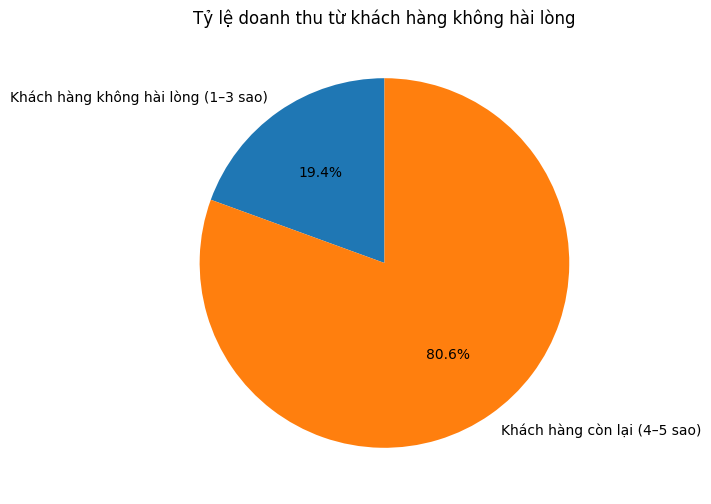

In [260]:
labels = ['Kh√°ch h√†ng kh√¥ng h√†i l√≤ng (1‚Äì3 sao)', 'Kh√°ch h√†ng c√≤n l·∫°i (4‚Äì5 sao)']
values = [low_review_revenue, total_revenue - low_review_revenue]
colors = ['#ff6b6b', '#4ecdc4']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('T·ª∑ l·ªá doanh thu t·ª´ kh√°ch h√†ng kh√¥ng h√†i l√≤ng')
plt.show()

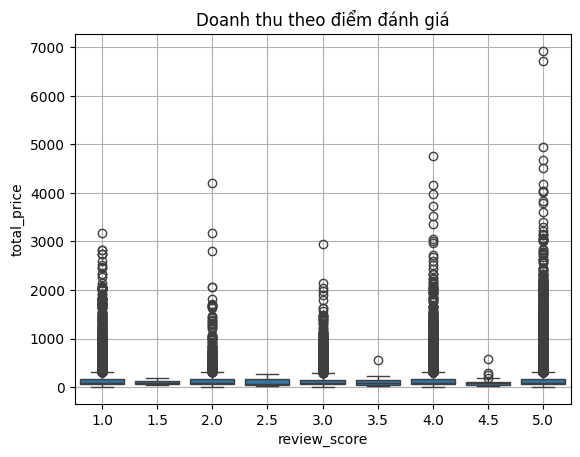

In [261]:
sns.boxplot(x='review_score', y='total_price', data=df_clean)
plt.title("Doanh thu theo ƒëi·ªÉm ƒë√°nh gi√°")
plt.grid(True)
plt.show()

#D·ª± ƒëo√°n

In [262]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in datetime_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        df_clean[f'{col}_day'] = df_clean[col].dt.day
        df_clean[f'{col}_month'] = df_clean[col].dt.month
        df_clean[f'{col}_weekday'] = df_clean[col].dt.weekday
        df_clean[f'{col}_hour'] = df_clean[col].dt.hour


In [263]:
df_clean['freight_ratio'] = df_clean['freight_value'] / (df_clean['total_price'] + 1e-6)
df_clean['price_per_kg'] = df_clean['total_price'] / (df_clean['product_weight_g'] + 1e-6)
df_clean['product_volume_cm3'] = df_clean['product_length_cm'] * df_clean['product_width_cm'] * df_clean['product_height_cm']
df_clean['weight_x_delay'] = df_clean['product_weight_g'] * df_clean['delivery_delay']

for col in ['total_price', 'freight_value', 'product_weight_g', 'delivery_time', 'estimated_time']:
    df_clean[f'log1p_{col}'] = np.log1p(df_clean[col])

In [264]:
features = [
    'freight_value', 'review_score', 'product_weight_g', 'delivery_delay',
    'order_month', 'order_dayofweek', 'order_hour',
    'product_category_name_english', 'payment_type',
    'seller_state', 'customer_state',

    'freight_ratio', 'price_per_kg', 'weight_x_delay', 'product_volume_cm3',
    'log1p_total_price', 'log1p_freight_value', 'log1p_product_weight_g',
    'log1p_delivery_time', 'log1p_estimated_time',
    'is_late', 'low_review',

    'order_purchase_timestamp_day',
    'order_purchase_timestamp_weekday',
    'order_purchase_timestamp_hour'
]

In [265]:
df_model = df_clean[features + ['total_price']].copy()

# Lo·∫°i b·ªè to√†n b·ªô c·ªôt datetime c√≤n s√≥t l·∫°i
datetime_cols = df_model.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns
df_model = df_model.drop(columns=datetime_cols, errors='ignore')

df_model = pd.get_dummies(df_model, drop_first=True)

# L√†m s·∫°ch d·ªØ li·ªáu
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()
df_model = df_model.astype(float)

X = df_model.drop('total_price', axis=1)
y = df_model['total_price']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# L·∫•y c√°c bi·∫øn c√≥ √Ω nghƒ©a th·ªëng k√™ (p-value ‚â§ 0.05)
significant_vars = model.pvalues[model.pvalues <= 0.05].index
X_significant = X[significant_vars]
model_refined = sm.OLS(y, X_significant).fit()

print(model_refined.summary())



                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2593.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        06:27:40   Log-Likelihood:            -6.6142e+05
No. Observations:              109365   AIC:                         1.323e+06
Df Residuals:                  109264   BIC:                         1.324e+06
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [266]:
# coef = model.params
# pvals = model.pvalues

# # T·∫°o DataFrame ch·ª©a th√¥ng tin
# summary_df = pd.DataFrame({
#     'variable': coef.index,
#     'coefficient': coef.values,
#     'p_value': pvals.values
# })

# summary_df = summary_df[summary_df['variable'] != 'const']

# # L·∫•y top 10 bi·∫øn c√≥ ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t (d·ª±a tr√™n tr·ªã tuy·ªát ƒë·ªëi c·ªßa h·ªá s·ªë)
# top10 = summary_df.reindex(summary_df['coefficient'].abs().sort_values(ascending=False).index).head(10)

# # V·∫Ω bi·ªÉu ƒë·ªì
# plt.figure(figsize=(10, 6))
# bars = plt.barh(top10['variable'][::-1], top10['coefficient'][::-1], color='skyblue')
# plt.xlabel('H·ªá s·ªë h·ªìi quy')
# plt.title('Top 10 bi·∫øn ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t ƒë·∫øn doanh thu')
# plt.axvline(0, color='gray', linewidth=0.8)
# plt.tight_layout()
# plt.show()

#D·ª± ƒëo√°n t∆∞∆°ng lai

In [267]:
df_clean['order_purchase_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
df_clean['order_purchase_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.to_timestamp()
df_clean['order_purchase_day'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()

In [268]:
# def forecast_by_time_mlr(df, time_freq='M', future_steps=6):

#     df = df.copy()
#     df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
#     df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
#     df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

#     # T√≠nh s·ªë ng√†y giao tr·ªÖ
#     df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
#     df['delivery_delay'] = df['delivery_delay'].fillna(0)

#     # ƒê·∫£m b·∫£o c·ªôt th·ªùi gian l√† c·ªôt, kh√¥ng ph·∫£i index
#     if df.index.name == 'order_purchase_timestamp':
#         df = df.reset_index()

#     df_indexed = df.set_index('order_purchase_timestamp')

#     # Resample (g·ªôp theo th·ªùi gian)
#     agg_df = df_indexed.resample(time_freq).agg({
#         'total_price': 'sum',
#         'freight_value': 'mean',
#         'review_score': 'mean',
#         'product_weight_g': 'mean',
#         'delivery_delay': 'mean'
#     }).dropna().reset_index()

#     # T·∫°o ƒë·∫∑c tr∆∞ng
#     agg_df['month'] = agg_df['order_purchase_timestamp'].dt.month
#     agg_df['time_idx'] = np.arange(len(agg_df))

#     # Bi·∫øn ƒë·∫ßu v√†o v√† m·ª•c ti√™u
#     X = agg_df[['freight_value', 'review_score', 'product_weight_g', 'delivery_delay', 'month']]
#     y = agg_df['total_price']

#     model = LinearRegression()
#     model.fit(X, y)

#     # T·∫°o d·ªØ li·ªáu ƒë·∫ßu v√†o cho t∆∞∆°ng lai
#     avg_vals = X.mean()
#     last_month = agg_df['month'].iloc[-1]
#     future_X = pd.DataFrame([
#         {
#             'freight_value': avg_vals['freight_value'],
#             'review_score': avg_vals['review_score'],
#             'product_weight_g': avg_vals['product_weight_g'],
#             'delivery_delay': avg_vals['delivery_delay'],
#             'month': (last_month + i - 1) % 12 + 1
#         }
#         for i in range(1, future_steps + 1)
#     ])

#     future_y = model.predict(future_X)

#     # T·∫°o m·ªëc th·ªùi gian t∆∞∆°ng lai
#     last_date = agg_df['order_purchase_timestamp'].iloc[-1]
#     if time_freq == 'M':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')
#         label = 'th√°ng'
#     elif time_freq == 'W':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=future_steps, freq='W-MON')
#         label = 'tu·∫ßn'
#     elif time_freq == 'D':
#         future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=future_steps, freq='D')
#         label = 'ng√†y'
#     else:
#         raise ValueError("time_freq ph·∫£i l√† 'M', 'W', ho·∫∑c 'D'.")

#     # V·∫Ω bi·ªÉu ƒë·ªì
#     plt.figure(figsize=(10, 4))
#     plt.plot(agg_df['order_purchase_timestamp'], y, label='Doanh thu th·ª±c t·∫ø', marker='o')
#     plt.plot(future_dates, future_y, '--o', color='red', label='D·ª± ƒëo√°n t∆∞∆°ng lai')
#     plt.title(f'D·ª± ƒëo√°n doanh thu theo {label} (Multiple Linear Regression)')
#     plt.xlabel('Th·ªùi gian')
#     plt.ylabel('Doanh thu')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     return agg_df, model

In [269]:

# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='M', future_steps=3)

In [270]:
# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='W', future_steps=8)

In [271]:
# agg_df, model = forecast_by_time_mlr(df_clean, time_freq='D', future_steps=30)

In [272]:
feature_cols = ['freight_value', 'review_score', 'product_weight_g', 'delivery_delay', 'month']
# X = agg_df[feature_cols]
# y = agg_df['total_price']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [273]:
from sklearn.linear_model import LinearRegression

feature_cols = X.columns
coefs = pd.Series(model.coef_, index=feature_cols)
coefs_sorted = coefs.abs().sort_values(ascending=False)

print("Top 5 bi·∫øn ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t ƒë·∫øn doanh thu:")
print(coefs[coefs_sorted.index[:5]])


Top 5 bi·∫øn ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t ƒë·∫øn doanh thu:
freight_ratio                                                          728.102572
product_category_name_english_computers                                404.684593
log1p_total_price                                                      313.712950
product_category_name_english_furniture_mattress_and_upholstery       -181.337752
product_category_name_english_small_appliances_home_oven_and_coffee    164.079601
dtype: float64


In [274]:
# plt.figure(figsize=(8, 5))
# coefs[coefs_sorted.index[:5]].sort_values().plot(kind='barh', color='skyblue')
# plt.title('Top 5 bi·∫øn ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t ƒë·∫øn doanh thu')
# plt.xlabel('H·ªá s·ªë h·ªìi quy')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

#D√πng prophet

In [275]:
# T·∫°o c√°c m·ªëc th·ªùi gian t·ª´ c·ªôt timestamp g·ªëc
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
df_clean['order_week'] = df_clean['order_purchase_timestamp'].dt.to_period('W').dt.start_time
df_clean['order_day'] = df_clean['order_purchase_timestamp'].dt.to_period('D').dt.to_timestamp()

# T·ªïng doanh thu theo t·ª´ng m·ª©c ƒë·ªô th·ªùi gian
monthly_df = df_clean.groupby('order_month')['total_price'].sum().reset_index().rename(columns={'order_month': 'ds', 'total_price': 'y'})
weekly_df = df_clean.groupby('order_week')['total_price'].sum().reset_index().rename(columns={'order_week': 'ds', 'total_price': 'y'})
daily_df = df_clean.groupby('order_day')['total_price'].sum().reset_index().rename(columns={'order_day': 'ds', 'total_price': 'y'})


In [276]:
def forecast_revenue(df, freq, periods, granularity):
    model = Prophet()
    model.fit(df)

    try:
        df_cv = cross_validation(
            model,
            initial='365 days',
            period='90 days',
            horizon='90 days'
        )
        df_p = performance_metrics(df_cv)
        print(f"[ƒê√ÅNH GI√Å M√î H√åNH - {granularity}]")
        print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())
    except Exception as e:
        print("Kh√¥ng th·ªÉ ƒë√°nh gi√° m√¥ h√¨nh:", e)

    # T·∫°o dataframe d·ª± b√°o
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    # G·ªôp k·∫øt qu·∫£ d·ª± b√°o v·ªõi d·ªØ li·ªáu th·ª±c t·∫ø
    forecast = forecast.merge(df, on='ds', how='left')
    forecast['granularity'] = granularity

    # V·∫Ω bi·ªÉu ƒë·ªì
    fig = model.plot(forecast)
    plt.title(f'D·ª± ƒëo√°n doanh thu theo {granularity}')
    plt.xlabel('Th·ªùi gian')
    plt.ylabel('Doanh thu')
    plt.grid(True)

    # Th√™m ƒë∆∞·ªùng chia th·ªùi gian d·ª± b√°o
    split_date = df['ds'].max()
    plt.axvline(x=split_date, color='gray', linestyle='--', label='B·∫Øt ƒë·∫ßu d·ª± b√°o')
    # plt.legend()
    plt.tight_layout()
    plt.show()

    return forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'granularity']]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/ex2c5eqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/zaiqip32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59527', 'data', 'file=/tmp/tmpvrriwmmq/ex2c5eqy.json', 'init=/tmp/tmpvrriwmmq/zaiqip32.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelbu15mm3v/prophet_model-20250628062742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:42 - cmdstanpy - INFO - Chain [1] start processing
I

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/155h9dl8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/wobuocgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72880', 'data', 'file=/tmp/tmpvrriwmmq/155h9dl8.json', 'init=/tmp/tmpvrriwmmq/wobuocgw.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_model9a3mlw_z/prophet_model-20250628062742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/pv1gbbub.json
DEBUG:cmdstanpy:input tempfil

[ƒê√ÅNH GI√Å M√î H√åNH - month]
  horizon            mae           rmse      mape  coverage
0 27 days   93315.199598  114698.958454  0.106774       0.5
1 29 days  290226.355137  290226.355137  0.286941       0.0
2 58 days   42949.587335   59527.981351  0.037951       1.0
3 59 days  338139.286536  338139.286536  0.329158       0.0
4 88 days  155846.603323  155846.603323  0.138067       0.0


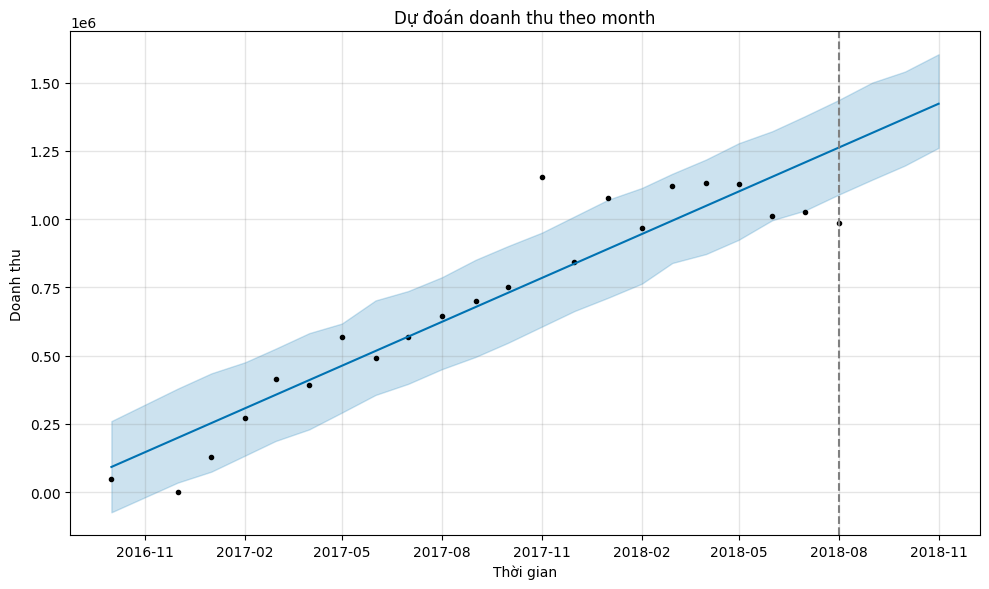

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/6w5btovz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/31hbg1me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35740', 'data', 'file=/tmp/tmpvrriwmmq/6w5btovz.json', 'init=/tmp/tmpvrriwmmq/31hbg1me.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelf8ukqbq3/prophet_model-20250628062743.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:44 - cmdstanpy - INFO - Chai

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/l0qv6bji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/l8hktzsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2076', 'data', 'file=/tmp/tmpvrriwmmq/l0qv6bji.json', 'init=/tmp/tmpvrriwmmq/l8hktzsq.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_model8nxvxkip/prophet_model-20250628062744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/o7f9uvir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/0v6eiij3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[ƒê√ÅNH GI√Å M√î H√åNH - week]
  horizon           mae          rmse      mape  coverage
0  6 days  26461.890055  33563.111751  0.108500  1.000000
1 11 days  22756.985115  31153.444372  0.097463  1.000000
2 12 days  27736.018094  32494.917417  0.117627  1.000000
3 13 days  22827.122044  24917.039492  0.093528  1.000000
4 18 days  46876.318476  55685.901121  0.269681  0.666667


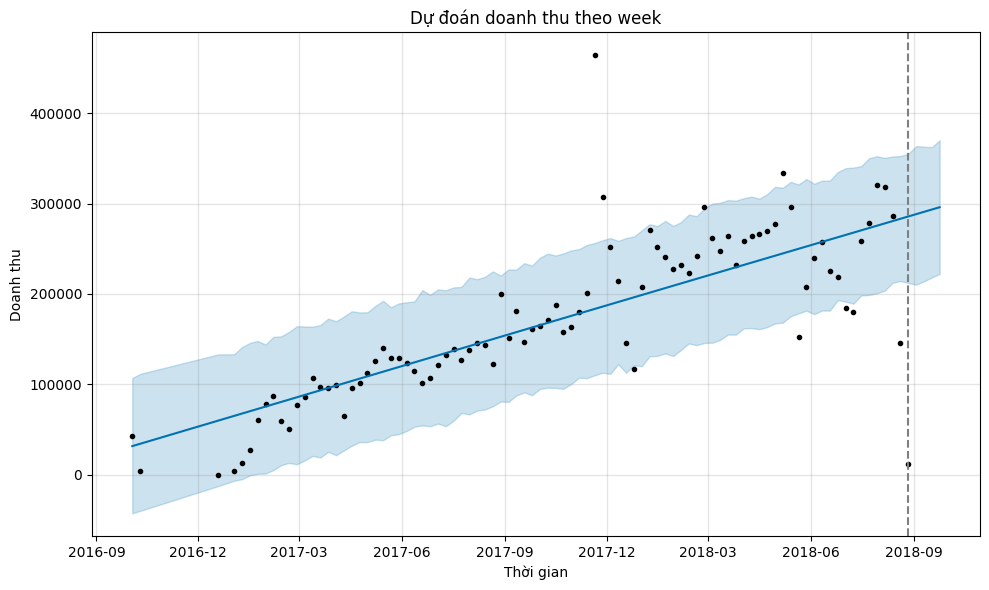

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/lrak02gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/5ssnm6sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19381', 'data', 'file=/tmp/tmpvrriwmmq/lrak02gl.json', 'init=/tmp/tmpvrriwmmq/5ssnm6sm.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelfejsuj6b/prophet_model-20250628062745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cut

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/cjzv50t7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/2m7v3p8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51094', 'data', 'file=/tmp/tmpvrriwmmq/cjzv50t7.json', 'init=/tmp/tmpvrriwmmq/2m7v3p8x.json', 'output', 'file=/tmp/tmpvrriwmmq/prophet_modelewfxa0r_/prophet_model-20250628062746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/c6am9ep6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvrriwmmq/vbynsmrd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[ƒê√ÅNH GI√Å M√î H√åNH - day]
  horizon          mae         rmse      mape  coverage
0  9 days  4972.526937  5868.225180  0.147865  0.925926
1 10 days  5291.796705  6030.397517  0.157246  0.925926
2 11 days  5385.390129  6320.080913  0.157055  0.925926
3 12 days  6121.941187  7052.613256  0.183804  0.888889
4 13 days  6226.439364  7314.276996  0.187707  0.888889


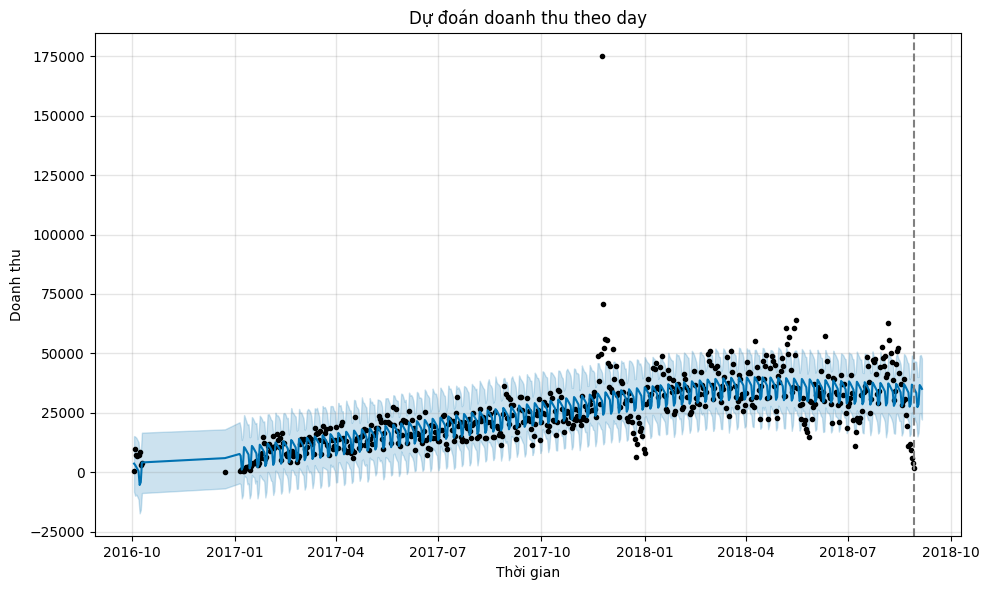

In [277]:
forecast_months = forecast_revenue(monthly_df, freq='MS', periods=3, granularity='month')
forecast_weeks  = forecast_revenue(weekly_df, freq='W-MON', periods=4, granularity='week')
forecast_days   = forecast_revenue(daily_df, freq='D', periods=7, granularity='day')

D·ª± b√°o theo "month"
- MAPE	0.08 ‚Äì 0.32 (dao ƒë·ªông m·∫°nh)
- MAE	L√™n ƒë·∫øn 338k, c√≥ l√∫c ch·ªâ 42k
- Coverage	Ch·ªâ c√≥ 1 d√≤ng ƒë·∫°t 1.0, c√≤n l·∫°i g·∫ßn 0

Nh·∫≠n x√©t:
- Kh√¥ng ·ªïn ƒë·ªãnh ‚Äì ƒë·ªô sai s·ªë l·ªõn v√† coverage qu√° th·∫•p

D·ª± b√°o theo "week"
- MAPE	~0.09 ‚Äì 0.26
- MAE	22k‚Äì46k
- Coverage	R·∫•t t·ªët (ƒëa s·ªë ƒë·∫°t 1.0)

Nh·∫≠n x√©t:
- M√¥ h√¨nh ·ªïn ƒë·ªãnh, ƒë·ªô sai s·ªë h·ª£p l√Ω, coverage cao
- D·ª± b√°o tu·∫ßn l√† kh√° hi·ªáu qu·∫£

D·ª± b√°o theo "day"
- MAPE	0.14 ‚Äì 0.18
- MAE	4.9k ‚Äì 6.2k
- Coverage	Cao (>= 0.92)

Nh·∫≠n x√©t:
- T·ªët, ƒë·ªô sai s·ªë t∆∞∆°ng ƒë·ªëi th·∫•p
- Coverage cao ‚Üí m√¥ h√¨nh ·ªïn ƒë·ªãnh

In [278]:
forecast_all = pd.concat([forecast_months, forecast_weeks, forecast_days], ignore_index=True)

In [279]:
# forecast_all.to_csv("forecast_all.csv", index=False)

In [280]:
# # H√†m t·∫°o forecast theo t·ª´ng m·ª©c th·ªùi gian
# def forecast_prophet(df, freq, label, periods, file_name):
#     df_grouped = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq=freq))['payment_value'].sum().reset_index()
#     df_grouped.columns = ['ds', 'y']
#     df_grouped = df_grouped[df_grouped['y'] > 0]  # b·ªè ng√†y kh√¥ng c√≥ ƒë∆°n

#     model = Prophet()
#     model.fit(df_grouped)

#     future = model.make_future_dataframe(periods=periods, freq=freq)
#     forecast = model.predict(future)

#     # Ch·ªâ l·∫•y c·ªôt c·∫ßn thi·∫øt
#     output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#     output.to_csv(file_name, index=False)
#     print(f"‚úÖ ƒê√£ l∆∞u file: {file_name}")

# # T·∫°o t·ª´ng file
# forecast_prophet(df_clean, freq='MS', label='th√°ng', periods=3, file_name='forecast_months.csv')
# forecast_prophet(df_clean, freq='W-MON', label='tu·∫ßn', periods=4, file_name='forecast_weeks.csv')
# forecast_prophet(df_clean, freq='D', label='ng√†y', periods=7, file_name='forecast_days.csv')


In [281]:
# df_clean.to_csv('olist_data_clean.csv', index=False, encoding='utf-8-sig')

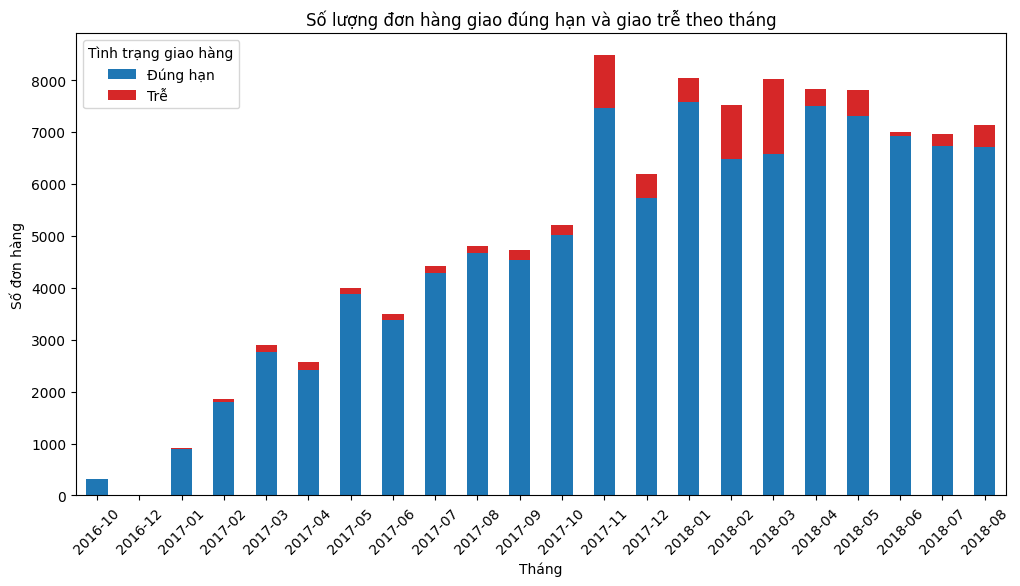

In [282]:
delay_by_month = df_clean.groupby(['order_month', 'is_late']).size().unstack(fill_value=0)
delay_by_month.index = delay_by_month.index.strftime('%Y-%m')
# V·∫Ω bi·ªÉu ƒë·ªì stacked bar chart
delay_by_month.plot(kind='bar', stacked=True,
                    color=['#1f77b4', '#d62728'], figsize=(12, 6))

plt.title('S·ªë l∆∞·ª£ng ƒë∆°n h√†ng giao ƒë√∫ng h·∫°n v√† giao tr·ªÖ theo th√°ng')
plt.xlabel('Th√°ng')
plt.ylabel('S·ªë ƒë∆°n h√†ng')
plt.xticks(rotation=45)
plt.legend(title='T√¨nh tr·∫°ng giao h√†ng', labels=['ƒê√∫ng h·∫°n', 'Tr·ªÖ'])
plt.show()

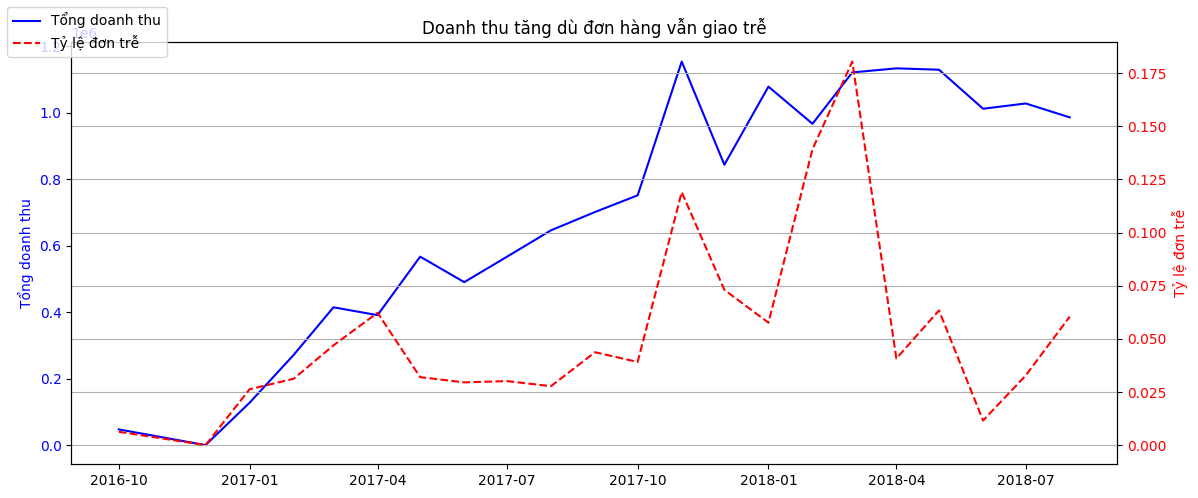

In [284]:
df1 = df_clean.copy()
monthly = df1.groupby('order_month').agg({
    'total_price': 'sum',
    'is_late': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monthly['order_month'], monthly['total_price'], color='blue', label='T·ªïng doanh thu')
ax1.set_ylabel('T·ªïng doanh thu', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(monthly['order_month'], monthly['is_late'], color='red', linestyle='--', label='T·ª∑ l·ªá ƒë∆°n tr·ªÖ')
ax2.set_ylabel('T·ª∑ l·ªá ƒë∆°n tr·ªÖ', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Doanh thu tƒÉng d√π ƒë∆°n h√†ng v·∫´n giao tr·ªÖ')
fig.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-287-2346187850.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freight_stats = df_clean.groupby('freight_group')['total_price'].sum().reset_index()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128667 (\N{ARTICULATED LORRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


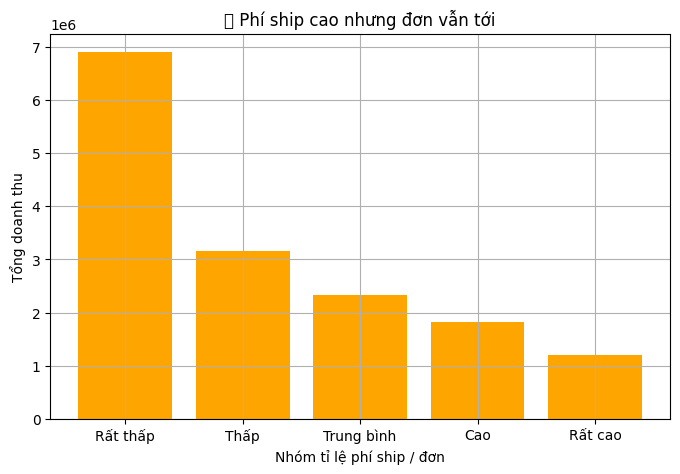

In [287]:

df_clean['freight_ratio'] = df_clean['freight_value'] / (df_clean['total_price'] + 1e-6)

# Nh√≥m theo m·ª©c ph√≠ v·∫≠n chuy·ªÉn (chia nh√≥m theo percentile)
df_clean['freight_group'] = pd.qcut(df_clean['freight_ratio'], q=5, labels=['R·∫•t th·∫•p', 'Th·∫•p', 'Trung b√¨nh', 'Cao', 'R·∫•t cao'])
freight_stats = df_clean.groupby('freight_group')['total_price'].sum().reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(freight_stats['freight_group'], freight_stats['total_price'], color='orange')
plt.xlabel("Nh√≥m t·ªâ l·ªá ph√≠ ship / ƒë∆°n")
plt.ylabel("T·ªïng doanh thu")
plt.title("üöõ Ph√≠ ship cao nh∆∞ng ƒë∆°n v·∫´n t·ªõi")
plt.grid(True)
plt.show()